<a href="https://colab.research.google.com/github/Ltpordh27/CLIP_text_image_matching/blob/main/CLIP_text_image_matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Required libraries, loading CLIP model

In [110]:
import torch
import transformers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

In [ ]:
!unzip /content/drive/MyDrive/dataset.zip

In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [ ]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [ ]:
model, preprocess = clip.load("ViT-B/32")
model.to(device).eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77


In [ ]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x78c6655c3060>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

Creating dataset for images

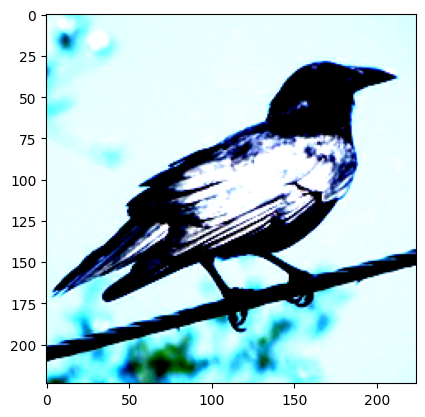

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from os import listdir

class ImageSet(Dataset):

    def __init__(self, root, filenames, transform=None) -> None:

        self.root = root
        self.filenames = filenames
        self.transform = transform

    def __len__(self):

        return len(self.filenames)

    def __getitem__(self, index):

        if torch.is_tensor(index):
            idx = index.tolist()

        path = root + self.filenames[index]
        image = Image.open(path)
        if self.transform:
            image = self.transform(image)

        return image

root = 'dataset/'
names = listdir(root)
names.sort()

image_set = ImageSet(root, names, transform=preprocess)
image_loader = DataLoader(image_set, batch_size=16, shuffle=False)

random_image = next(iter(image_loader))[0]

plt.imshow(random_image.permute(1, 2, 0))

In [ ]:
names

Computing image embeddings

In [ ]:
tokens = torch.empty((len(image_set), 512))

batch_size = image_loader.batch_size
for i, batch in enumerate(image_loader):
    with torch.no_grad():
        batch = batch.to(device)
        outputs = model.encode_image(batch)
        tokens[batch_size * i:batch_size * (i + 1), :] = outputs

Computing top-k similar images by cosine similarity

In [ ]:
def cosine_similarity(text_embeddings, image_embeddings):

    image_embeddings /= image_embeddings.norm(dim=1, keepdim=True)
    text_embeddings /= text_embeddings.norm(dim=1, keepdim=True)
    cosines = text_embeddings @ image_embeddings.T
    return cosines

def top_k(similarity, k=6):

    top = similarity.argsort(dim=1, descending=True)
    return top[:, :k]

sim = cosine_similarity(tokens, tokens)
torch.diagonal(sim).zero_()
top = top_k(sim)

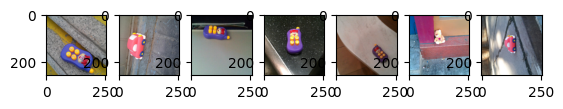

In [ ]:
idx = 2012

fig, axes = plt.subplots(1, 7)
image = Image.open(root + names[idx])
axes[0].imshow(image)
for i, j in enumerate(top[idx]):
    image = Image.open(root + names[j])
    axes[i + 1].imshow(image)

Finding images by text description

In [ ]:
descriptions = ['This is a black bicycle',
                'This is a green bicycle',
                'A bird sitting on a tree branch',
                'A flying bird',
                'This is a lamp',
                'This is a chandelier',
                'This is a wasp',
                'This is a plush toy',
                'This is a toy car']

text_tokens = clip.tokenize(descriptions).to(device)
with torch.no_grad():
    text_embeddings = model.encode_text(text_tokens).float().cpu()

In [ ]:
sim = cosine_similarity(text_embeddings, tokens)
torch.diagonal(sim)
top = top_k(sim)

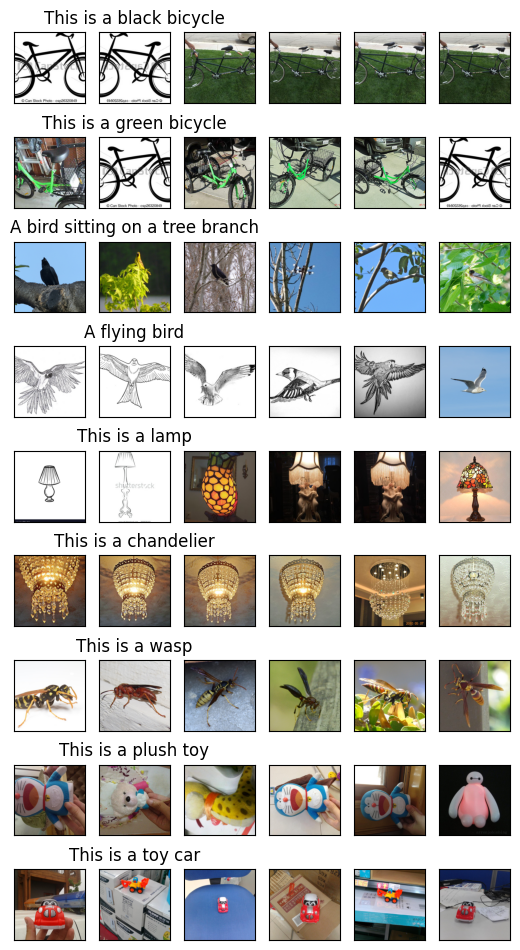

In [ ]:
fig, axes = plt.subplots(9, 6)
fig.set_figheight(12)

for k, text in enumerate(descriptions):
    for i, j in enumerate(top[k]):
        image = Image.open(root + names[j])
        axes[k, i].imshow(image)
        axes[k, i].xaxis.set_visible(False)
        axes[k, i].yaxis.set_visible(False)
    axes[k, 1].set_title(descriptions[k])